In [1]:
import numpy as np
import torch
import scipy.stats as scs
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from pyhmc import hmc

# looking at outputs from hpc

In [2]:
'''
samples_100burn_10epoch = np.load('GGCNN_HM100burnin_N01_10_0_10epoch_samples_mnist.npy')
samples_100burn_unlim_epoch = np.load('GGCNN_HM100burnin_N01_10_0_samples_mnist.npy')
samples_10000burn_10epoch = np.load('GGCNN_HM10000burnin_N01_10_0_10epoch_samples_mnist.npy')
samples_10000burn_unlim_epoch = np.load('GGCNN_HM10000burnin_N01_10_0_samples_mnist.npy')
'''
'''samples_100burn_10epoch =       np.load('GGCNN_HM100burnin_N01_10_1_10epoch_samples_mnist.npy')
samples_100burn_unlim_epoch =   np.load('GGCNN_HM100burnin_N01_10_2_10epoch_samples_mnist.npy')
samples_10000burn_10epoch =     np.load('GGCNN_HM10000burnin_N01_10_1_10epoch_samples_mnist.npy')
samples_10000burn_unlim_epoch = np.load('GGCNN_HM10000burnin_N01_10_2_10epoch_samples_mnist.npy')
'''

# best: logsumexpbigGGCNN_HM100burnin_N01_1_500epoch_samples_mnist 36.0952

samples_100burn_10epoch =       np.load('logsumexpbigGGCNN_HM100burnin_N01_1_500epoch_samples_mnist.npy')
samples_100burn_unlim_epoch =   np.load('logsumexpsimple_NNETHM100burnin_N01_1_500epoch_samples_mnist.npy')
samples_10000burn_10epoch =     np.load('logsumexpsimple_CNNHM1000burnin_N01_1_500epoch_samples_mnist.npy')
samples_10000burn_unlim_epoch = np.load('logsumexpsimple_NNETHM1000burnin_N01_1_500epoch_samples_mnist.npy')



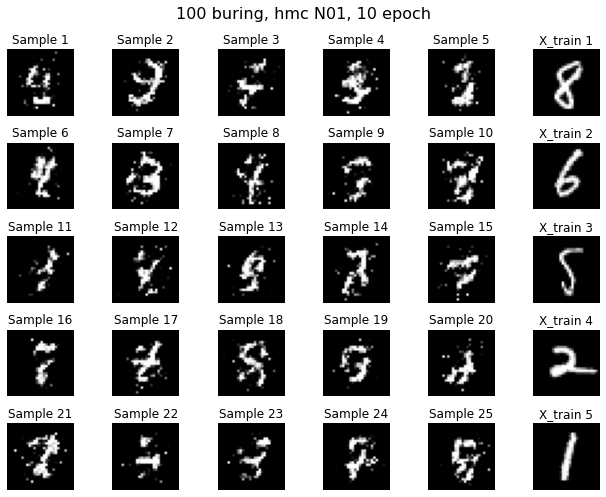

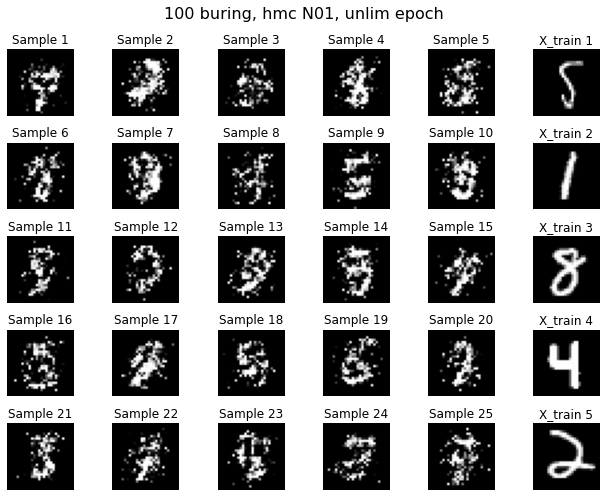

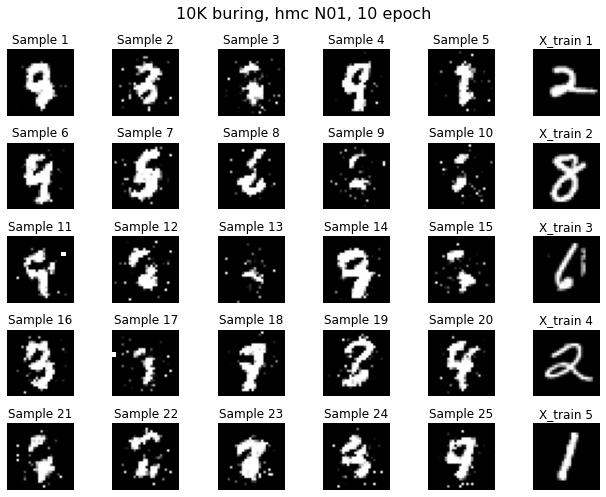

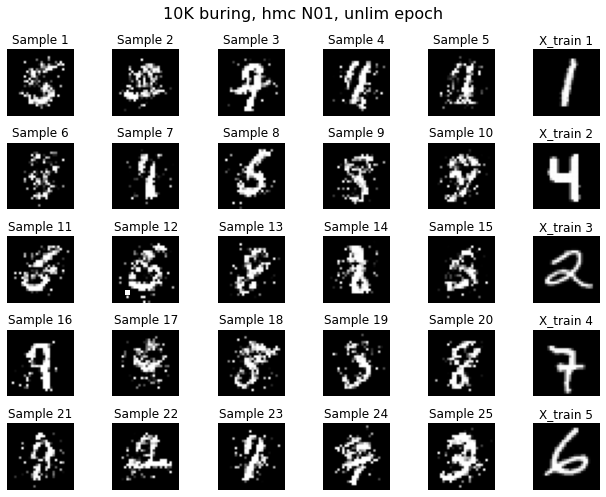

In [8]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, samples_100burn_19epoch, and X_train are already defined

fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle("100 buring, hmc N01, 10 epoch", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.tensor(samples_100burn_10epoch[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[i]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle("100 buring, hmc N01, unlim epoch", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.tensor(samples_100burn_unlim_epoch[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[(1+i)*2]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, samples_100burn_19epoch, and X_train are already defined

fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle("10K buring, hmc N01, 10 epoch", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.tensor(samples_10000burn_10epoch[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[(1+i)*3]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle("10K buring, hmc N01, unlim epoch", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.tensor(samples_10000burn_unlim_epoch[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[(1+i)*4]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()




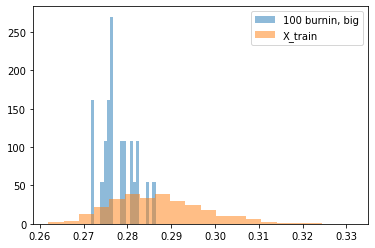

In [160]:
ratio_std_within = [np.std(scs.norm.cdf(samples_100burn_10epoch[k].reshape(-1))) for k in range(25)]
plt.hist(ratio_std_within, bins=20,alpha=0.5, label='100 burnin, big',density=True)
X_train_std_within = [np.std(scs.norm.cdf(X_train[k].reshape(-1))) for k in range(1000)]
plt.hist(X_train_std_within, bins=20,alpha=0.5, label='X_train',density=True)
plt.legend()
plt.show()

In [174]:
import torch
import ot

def W2(x, y):
    x = x.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    a = np.ones(x.shape[0]) / x.shape[0]
    b = np.ones(y.shape[0]) / y.shape[0]
    M = ot.dist(x, y)
    return torch.sqrt(torch.tensor(ot.emd2(a, b, M)))
# Example usage with MNIST data
samples_6 = torch.randn(100, 1, 28, 28)  # Example samples

# Reshape the data to 1D vectors
X_test_reshaped = X_test.reshape(-1, 28*28).float()
samples_6_reshaped = samples_6.reshape(-1, 28*28).float()

# Compute the Wasserstein distance
print('100burnin 10 epoch', W2(torch.tensor(X_test_reshaped), torch.tensor(samples_10000burn_unlim_epoch)))

C:\Users\david\AppData\Local\Temp\ipykernel_26564\2054658406.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print('100burnin 10 epoch', W2(torch.tensor(X_test_reshaped), torch.tensor(samples_10000burn_unlim_epoch)))


100burnin 10 epoch tensor(38.4354)


In [20]:
import ot
def W2(x,y):
    return torch.sqrt(ot.emd2(torch.ones(x.shape[0])/x.shape[0], torch.ones(y.shape[0])/y.shape[0], ot.dist(x, y)))


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [9]:
print('100burnin 10 epoch',W2(X_test.reshape(-1,28*28).float(),torch.tensor(samples_6).reshape(-1,28*28).float())
)

100burnin 10 epoch tensor(36.4526)


In [172]:
print('100burnin 10 epoch',W2(X_test.reshape(-1,28*28).float(),torch.tensor(samples_100burn_10epoch).reshape(-1,28*28).float())
)
print('100bunrin unlim epoch',W2(X_test.reshape(-1,28*28).float(),torch.tensor(samples_100burn_unlim_epoch).reshape(-1,28*28).float())
)
print('10Kburnin 10 epoch',W2(X_test.reshape(-1,28*28).float(),torch.tensor(samples_10000burn_10epoch).reshape(-1,28*28).float())
)
print('10K burnin unlim epoch',W2(X_test.reshape(-1,28*28).float(),torch.tensor(samples_10000burn_unlim_epoch).reshape(-1,28*28).float())
)
print('random noise',W2(X_test.reshape(-1,28*28).float(),torch.tensor(torch.randn(25,28,28)).reshape(-1,28*28).float())
)

100burnin 10 epoch tensor(36.0952)
100bunrin unlim epoch tensor(36.1429)


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\lp\__init__.py:571: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


10Kburnin 10 epoch tensor(41.3356)
10K burnin unlim epoch tensor(38.4354)


C:\Users\david\AppData\Local\Temp\ipykernel_26564\3343683724.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print('random noise',W2(X_test.reshape(-1,28*28).float(),torch.tensor(torch.randn(25,28,28)).reshape(-1,28*28).float())


random noise tensor(38.0029)


# Preliminary code

In [4]:
# load all mnist data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(990109)
torch.manual_seed(990109)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.view(784))])
trainset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
data_true = trainset.data.numpy()
data_true = data_true.reshape(data_true.shape[0], -1)



In [5]:
# Add Gaussian noise to dequentize
noise = scs.norm.rvs(0, 0.05, data_true.shape)
X_noisy_flat = (data_true + noise)

# Apply ECDF transformation
X_ecdf = np.zeros_like(X_noisy_flat)
ecdf_list = []
for dim in (range(X_noisy_flat.shape[1])):
    ecdf = ECDF(X_noisy_flat[:, dim])
    ecdf_list.append(ecdf)
    X_ecdf[:, dim] = np.clip(ecdf(X_noisy_flat[:, dim]), 1e-6, 1 - 1e-6)


In [6]:

# Apply inverse of standard normal CDF (ppf)
X_gaussian = scs.norm.ppf(X_ecdf).reshape(-1, 28,28)
y_gaussian = torch.ones(X_gaussian.shape[0], dtype=torch.long)
# make it a tensor with shape (n_samples, n_channels, height, width)
X_gaussian = torch.tensor(X_gaussian, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Split the data into training and testing sets (50/50 split)
X_train, X_test, y_train, y_test = train_test_split(X_gaussian, y_gaussian, test_size=0.5, random_state=42)
# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
def reverse_transform(example):
    ''' 
    Reverse the transformation applied to the data using the ECDFs.
    
    input:
        example: torch.Tensor - the transformed example, of shape (1, 28, 28)

    output:
        original_example: np.array - the original example, of shape (28, 28)
    '''
    # Convert the tensor to a numpy array and remove the channel dimension
    example = example.squeeze().numpy().reshape(-1)
    
    # Apply the inverse of the standard normal CDF (ppf)
    example = scs.norm.cdf(example)
    
    # Apply the inverse ECDF transformation
    original_example = np.zeros_like(example)
    for i in range(len(example)):
        ecdf = ecdf_list[i]
        original_example[i] = np.interp(example[i], ecdf.y, ecdf.x)
    
    # Reshape back to the original image shape and denormalize
    original_example = original_example.reshape(28, 28) 
    
    return original_example

In [180]:
# Define the ratio copula for MNIST data (28x28 images)

class CNN_ratio_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), normalising_cst=True, c=1.0, reg_lambda=1e-4):
        super(CNN_ratio_MNIST, self).__init__()
        self.normalising_cst = normalising_cst
        self.reg_lambda = reg_lambda

        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 1)  # Adjusted for 28x28 input images
        )

    def forward(self, x):
        log_r = self.model(x)
        if self.normalising_cst:
            log_r = log_r + self.c.log()
        return log_r
    
    def regularizer_logr(self,logr_p,logr_q):
        # Compute the L2 regularization term
        return self.reg_lambda * (torch.sum(logr_p ** 2) + torch.sum(logr_q ** 2))

In [181]:
from tqdm import tqdm

In [182]:
def loss_nce_logsumexp(logr_p, logr_q,p_size, q_size):
    v = q_size / p_size
    # Compute log(v + r_p) and log(v + r_q) using logsumexp for numerical stability
    log_v = torch.log(torch.tensor(v)) * torch.ones_like(logr_p)
    log_v_plus_r_p = torch.logsumexp(torch.stack([log_v, logr_p]), dim=0)
    log_v_plus_r_q = torch.logsumexp(torch.stack([log_v, logr_q]), dim=0)
    # Compute the loss using the numerically stable logsumexp results
    term1 = -(logr_p - log_v_plus_r_p).mean()
    term2 = -v * (log_v - log_v_plus_r_q).mean()
    
    return term1 + term2

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


In [10]:
a1 = 2*torch.randn(10,2)**2
a2 = -1e+3*(torch.randn(10,2)**2)
print(a1.exp().sum(),a2.exp().sum())
loss_nce(a1.exp(),a2.exp(),a1.shape[0],a2.shape[0]),loss_nce_logsumexp(a1,a2,a1.shape[0],a2.shape[0])


tensor(8501.5957) tensor(0.4853)


(tensor(0.3925), tensor(0.3925))

In [41]:
len(train_loader)

469

In [10]:


def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


# Define model
model_GG_CNN = CNN_ratio_MNIST(reg_lambda=1e-6)

# Define loss function and optimizer
optimizer = optim.Adam(model_GG_CNN.parameters())#, lr=0.0002, betas=(0.5, 0.999))

n_indep = 1

# Training loop
num_epochs = 1

GG_cov = np.cov(X_train.reshape(-1,28*28).T)

for epoch in tqdm(range(num_epochs)):
    model_GG_CNN.train()
    running_loss = 0.0
    noise_index = 0 

    epoch_GG_noise = torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=100*n_indep).reshape(-1,1,28,28)).float()
    for inputs, labels in (train_loader):
        optimizer.zero_grad()
        r_p = model_GG_CNN(inputs).squeeze()
        epoch_GG_noise_here = epoch_GG_noise[np.random.choice(epoch_GG_noise.shape[0], inputs.shape[0], replace=False)]
        r_q = model_GG_CNN(epoch_GG_noise_here).squeeze()
        noise_index += inputs.shape[0]
        loss = loss_nce_logsumexp(r_p, r_q,inputs.shape[0], epoch_GG_noise_here.shape[0])
        loss += model_GG_CNN.regularizer_logr(r_p, r_q)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {model_GG_CNN.c.item()}, r_p: {r_p.mean().item()}, r_q: {r_q.mean().item()}")



100%|██████████| 1/1 [00:21<00:00, 21.70s/it]

Epoch 1/1, Loss: 0.13884493885740543, c: 1.0122148990631104, r_p: 11.093338966369629, r_q: -5.391603469848633


In [183]:
# Define the ratio copula for MNIST data (28x28 images)
class W_ratio_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), normalising_cst=True, c=1.0, reg_lambda=1e-4, W_num=4):
        super(W_ratio_MNIST, self).__init__()
        self.normalising_cst = normalising_cst
        self.reg_lambda = reg_lambda

        if self.normalising_cst:
            self.c = nn.ParameterList([nn.Parameter(torch.tensor(c)) for _ in range(W_num)])


        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 100),  # Adjusted for 28x28 input images
            nn.LeakyReLU(0.2)
        )
        self.heads = nn.ModuleList([nn.Linear(100, 1) for _ in range(W_num)])
        self.W_num = W_num

    def forward(self,x):
        log_r = self.model(x)
        out = 0
        for w_idx,head in enumerate(self.heads):
            if self.normalising_cst:
                out += head(log_r) + self.c[w_idx].log()
            else:
                out += head(log_r)
        return out
    
    def forward_train(self,x, w_idx):
        log_r = self.model(x)
        if self.normalising_cst:
            log_r = log_r + self.c[w_idx].log()
        return self.heads[w_idx](log_r)

    def regularizer_logr(self, logr_p, logr_q):
        # Compute the L2 regularization term
        return self.reg_lambda * (torch.sum(logr_p ** 2) + torch.sum(logr_q ** 2))

model_GG_CNN = W_ratio_MNIST(W_num=10,reg_lambda=1e-10)
# Load the model from the specified path
model_path = 'W_CNN_500epoch_mnist_seed_0.pth'
model_GG_CNN.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [53]:
# this one uses logs and a regularizer
class CNN_ratio_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), normalising_cst=True, c=1.0, reg_lambda=1e-4):
        super(CNN_ratio_MNIST, self).__init__()
        self.normalising_cst = normalising_cst
        self.reg_lambda = reg_lambda

        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 64),  # Adjusted for 28x28 input images
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        log_r = self.model(x)
        if self.normalising_cst:
            log_r = log_r + self.c.log()
        return log_r
    
    def regularizer_logr(self,logr_p,logr_q):
        # Compute the L2 regularization term
        return self.reg_lambda * (torch.sum(logr_p ** 2) + torch.sum(logr_q ** 2))

model_GG_CNN = CNN_ratio_MNIST(reg_lambda=1e-10)
model_GG_CNN.load_state_dict(torch.load('logsumexpGGCNN_500epoch_mnist_seed_0.pth'))


<All keys matched successfully>

In [233]:
# this one uses logs and a regularizer and is just a simpler cnn
class CNN_ratio_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), normalising_cst=True, c=1.0, reg_lambda=1e-4):
        super(CNN_ratio_MNIST, self).__init__()
        self.normalising_cst = normalising_cst
        self.reg_lambda = reg_lambda

        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 64),  # Adjusted for 28x28 input images after one conv layer
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        log_r = self.model(x)
        if self.normalising_cst:
            log_r = log_r + self.c.log()
        return log_r
    
    def regularizer_logr(self,logr_p,logr_q):
        # Compute the L2 regularization term
        return self.reg_lambda * (torch.sum(logr_p ** 2) + torch.sum(logr_q ** 2))
model_GG_CNN = CNN_ratio_MNIST(reg_lambda=1e-10)
model_GG_CNN.load_state_dict(torch.load('logsumexpsimple_CNN500epoch_mnist_seed_1.pth'))


<All keys matched successfully>

In [103]:

def grad_logr_prior(x):
    # gradient of the ratio model with respect to the input
    print(x)
    x = torch.tensor(x, requires_grad=True).float().reshape(-1,1,28,28)
    logr = model_GG_CNN(x)
    grad_logr = torch.autograd.grad(logr.sum(), x)[0]
    return grad_logr.reshape(-1.28*28).detach().numpy() 

def logr(x,data):
    return model_GG_CNN(torch.tensor(x).float().reshape(-1,1,28,28)).detach().numpy()



In [234]:
model_GG_CNN.eval()


# LL computation

subset_num = 10000

X_train_flat = X_train.reshape(-1, 28*28)[:10000]
X_test_flat = X_test.reshape(-1, 28*28)[:10000]
GG_cov = np.cov(X_train_flat.T)
# Define the multivariate normal distribution with the given covariance matrix
GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor+torch.eye(GG_cov_tensor.size(0))*1e-6)
# Define the standard normal distribution
standard_normal = dist.Normal(loc=0, scale=1)
# Compute logpdf for the multivariate normal distribution
logpdf_multivariate_train = multivariate_normal.log_prob(X_train_flat)
logpdf_multivariate_test = multivariate_normal.log_prob(X_test_flat)
# Compute logpdf for the standard normal distribution and sum over the dimensions
logpdf_standard_train = standard_normal.log_prob(X_train_flat).sum(dim=1)
logpdf_standard_test = standard_normal.log_prob(X_test_flat).sum(dim=1)
# Compute GG_correction
GG_correction_train = logpdf_multivariate_train - logpdf_standard_train
GG_correction_test = logpdf_multivariate_test - logpdf_standard_test
# Compute means
mean_GG_correction_train = GG_correction_train.mean()
mean_GG_correction_test = GG_correction_test.mean()


# GG_CNN_Ratio

# Compute GG ratio alone
gg_CNN_ratio_train = model_GG_CNN(X_train[:10000]).mean()
gg_CNN_ratio_test = model_GG_CNN(X_test[:10000]).mean()

# Compute GG ratio corrected
gg_CNN_ratio_corrected_train = (GG_correction_train + model_GG_CNN(X_train[:10000])).mean()
gg_CNN_ratio_corrected_test = (GG_correction_test + model_GG_CNN(X_test[:10000])).mean()

# Print the results
print('GG CNN ratio alone', gg_CNN_ratio_train.item(), gg_CNN_ratio_test.item())
print('GG CNN ratio corrected ; GG_ratio full', gg_CNN_ratio_corrected_train.item(), gg_CNN_ratio_corrected_test.item())
# GG CNN ratio corrected ; GG_ratio full 159.52963256835938 124.81635284423828


GG CNN ratio alone 38.15361785888672 37.94213104248047
GG CNN ratio corrected ; GG_ratio full 186.4656219482422 151.60189819335938


In [235]:

def compute_logpdf_corrections(X, model, batch_size=64):
    X_flat = X.reshape(-1, 28*28)
    GG_cov = np.cov(X_flat.T)
    GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
    multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor)
    standard_normal = dist.Normal(loc=0, scale=1)

    logpdf_multivariate_sum = 0
    logpdf_standard_sum = 0
    model_log_sum = 0
    total_samples = 0

    for i in tqdm(range(0, X.shape[0], batch_size)):
        X_batch = X[i:i + batch_size]
        X_batch_flat = X_batch.reshape(-1, 28*28)
        logpdf_multivariate_sum += multivariate_normal.log_prob(X_batch_flat).sum().item()
        logpdf_standard_sum += standard_normal.log_prob(X_batch_flat).sum(dim=1).sum().item()
        model_log_sum += model(X_batch).sum().item()
        total_samples += X_batch.shape[0]

    avg_logpdf_multivariate = logpdf_multivariate_sum / total_samples
    avg_logpdf_standard = logpdf_standard_sum / total_samples
    avg_model_log = model_log_sum / total_samples

    GG_correction = avg_logpdf_multivariate - avg_logpdf_standard
    gg_CNN_ratio_corrected = GG_correction + avg_model_log

    return gg_CNN_ratio_corrected,avg_model_log

model_GG_CNN.eval()

# Compute GG ratio corrected for train and test sets
gg_CNN_ratio_corrected_train,gg_CNN_ratio_train = compute_logpdf_corrections(X_train, model_GG_CNN)
gg_CNN_ratio_corrected_test, gg_CNN_ratio_test = compute_logpdf_corrections(X_test, model_GG_CNN)

# Print the results
print('GG CNN ratio base train ; GG_ratio base test', gg_CNN_ratio_train, gg_CNN_ratio_test)
print('GG CNN ratio corrected train ; GG_ratio corrected test', gg_CNN_ratio_corrected_train, gg_CNN_ratio_corrected_test)

# GG CNN ratio corrected train ; GG_ratio corrected test 148.71070163370777 147.9634753560385
# maybe log? GG CNN ratio corrected train ; GG_ratio corrected test 139.56293915278124 138.83979228515634


100%|██████████| 469/469 [00:05<00:00, 90.57it/s]


GG CNN ratio base train ; GG_ratio base test 38.13724091796875 38.0190262491862
GG CNN ratio corrected train ; GG_ratio corrected test 175.64948948567715 174.81834760335295


In [246]:

# HMC

def sample_GG_hmc(GG_ratio_model, num_samples, num_runs_hmc, num_burnin):
    ''' 
    Sample from the ratio model with HMC.
    
    args:
        GG_ratio_model: nn.Module - the GG ratio copula model
        num_samples: int - the number of samples to generate per HMC run
        num_runs_hmc: int - the number of HMC runs, each giving num_samples draws
        num_burnin: int - the number of burn-in steps for a single HMC run
    
    returns:
        samples,log_pdf with
        samples: np.array - the generated samples of shape (num_runs_hmc*num_samples, 64)
        log_pdf: np.array - the log-pdf of the samples of shape (num_runs_hmc*num_samples,)
    '''
    GG_ratio_model.eval()
    def log_GGratio_gauss(x):
        ''' 
        Compute the log-pdf of the GG_ratio copula model and its gradient at x. 
        Takes the ratio model and adjusts it by the GG factor to make it into a copula.
        '''
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = torch.tensor(x.reshape(1, 1, 28, 28), dtype=torch.float32, requires_grad=True)
        x_flat = x_tensor.reshape(-1, 28*28)
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor+torch.eye(GG_cov_tensor.size(0))*1e-6)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate - logpdf_standard
        # Compute the log of the ratio model
        log_ratio = (GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction + log_prob_standard
        # Backward pass to compute the gradient
        fun.backward()
        fun = fun.squeeze()
        grad_wrt_x = x_tensor.grad.reshape(1, -1)[0]
        
        return np.array(fun.item(), dtype=np.float64), np.array(grad_wrt_x.detach().numpy(), dtype=np.float64)

    samples = np.zeros((num_runs_hmc, num_samples, 28*28))
    log_pdf = np.zeros((num_runs_hmc, num_samples))
    x0_noise = np.zeros((num_runs_hmc, 28, 28))
    for hmc_run in tqdm( range(num_runs_hmc)):

        '''# pick x0 with highest r(x0) from random noise
        x0_proposal = torch.randn(1000, 1, 28, 28)
        r_noise = model(x0_proposal)
        x0_run = x0_proposal[np.argmax(r_noise.detach().numpy().flatten())]    
        '''
        '''
        # pick x0 randomly from N(0,1) 
        x0_run = torch.randn(1, 1, 28, 28)
        '''
        '''
        # IS from GG
        GG_cov = np.cov(X_train.reshape(-1,28*28).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=10).reshape(-1,1,28,28)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)
        r_noise = GG_ratio_model(x0_run.reshape(-1,1,28,28))
        log_probs = torch.logsumexp(r_noise, dim=0)# Compute logsumexp normalized probabilities
        probs = torch.exp(r_noise - log_probs)
        x0_run = x0_run[np.random.choice(x0_run.shape[0], 1, replace=False, p = probs.detach().numpy().flatten())]
        '''
        GG_cov = np.cov(X_train.reshape(-1,28*28).T)
        x0_run_np = scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=1).reshape(1,1,28,28)
        x0_run = torch.tensor(x0_run_np, dtype=torch.float32)
        samples_, log_pdf_ = hmc(log_GGratio_gauss,
                            x0=x0_run.flatten().numpy(),
                            n_samples=num_samples,
                            return_logp=True,
                            n_burn=num_burnin)
        
        samples[hmc_run] = samples_
        log_pdf[hmc_run] = log_pdf_
        x0_noise[hmc_run] = x0_run

    return samples.reshape(-1,28*28), log_pdf.reshape(-1), x0_noise

sample_GG_CNN, log_pdf, x0_noises = sample_GG_hmc(GG_ratio_model=model_GG_CNN, 
                            num_samples=1, 
                            num_runs_hmc=25,
                            num_burnin=500)
print(sample_GG_CNN.shape)

100%|██████████| 25/25 [10:05<00:00, 24.23s/it]

(25, 784)


In [213]:
model_GG_CNN(torch.randn(100,1,28,28)).mean()

tensor(12.3172, grad_fn=<MeanBackward0>)

In [247]:
def log_GGratio_gauss(GG_ratio_model,x):
        ''' 
        Compute the log-pdf of the GG_ratio copula model and its gradient at x. 
        Takes the ratio model and adjusts it by the GG factor to make it into a copula.
        '''
        # compute the top part of a GG_ratio copula logpdf and the gradients of that
        x_tensor = x.reshape(1, 1, 28, 28)
        x_flat = x_tensor.reshape(-1, 28*28)
        # define N(Sigma) and N(0,1), then compute on x
        GG_cov_tensor = torch.tensor(GG_cov, dtype=torch.float32)
        multivariate_normal = dist.MultivariateNormal(loc=torch.zeros(28*28), covariance_matrix=GG_cov_tensor+torch.eye(GG_cov_tensor.size(0))*1e-6)
        standard_normal = dist.Normal(loc=0, scale=1)
        logpdf_multivariate = multivariate_normal.log_prob(x_flat)
        logpdf_standard = standard_normal.log_prob(x_flat).sum(dim=1)
        gg_correction = logpdf_multivariate - logpdf_standard
        # Compute the log of the ratio model
        log_ratio = (GG_ratio_model(x_tensor)).sum()
        # Compute the log probability of x under the standard normal distribution
        log_prob_standard = standard_normal.log_prob(x_tensor).sum()
        # Compute the final function value
        fun = log_ratio + gg_correction #+ log_prob_standard
        
        return fun.item()

sample_pdf = np.array([log_GGratio_gauss(model_GG_CNN,torch.tensor(sample_GG_CNN[k]).float().reshape(-1,1,28,28)) for k in tqdm(range(sample_GG_CNN.shape[0]))]
)
sample_pdf #array([129.77880859, 110.35611725, 179.03207397, 127.83757019,125.4307251 ]) with 1k burnin
x0_pdf = np.array([log_GGratio_gauss(model_GG_CNN,torch.tensor(x0_noises[k]).float().reshape(-1,1,28,28)) for k in tqdm(range(sample_GG_CNN.shape[0]))])
print(sample_pdf)
print(x0_pdf)

100%|██████████| 25/25 [00:00<00:00, 49.34it/s]

[489.38317871 244.34794617 520.95965576 393.93377686 394.65786743
 593.07098389 223.69854736 320.28674316 835.53100586 453.17901611
 314.54425049 647.24926758 210.95352173 745.06774902 252.58892822
 312.57275391 356.17230225 276.78967285 437.83938599 181.68856812
 235.52510071 243.48756409 302.84094238 305.01287842 502.34985352]
[ 86.57089996  35.41384888  20.06354523  53.03181458  94.62435913
  87.66113281  24.64039803  72.72874451 149.19857788 102.76747894
  58.90187836  79.33825684  43.77604675  54.34504318  27.74016953
  75.13495636  54.50734329  84.02035522  66.44847107  87.84608459
  45.9522171   83.38845062  60.38685608  96.01346588  75.16683197]


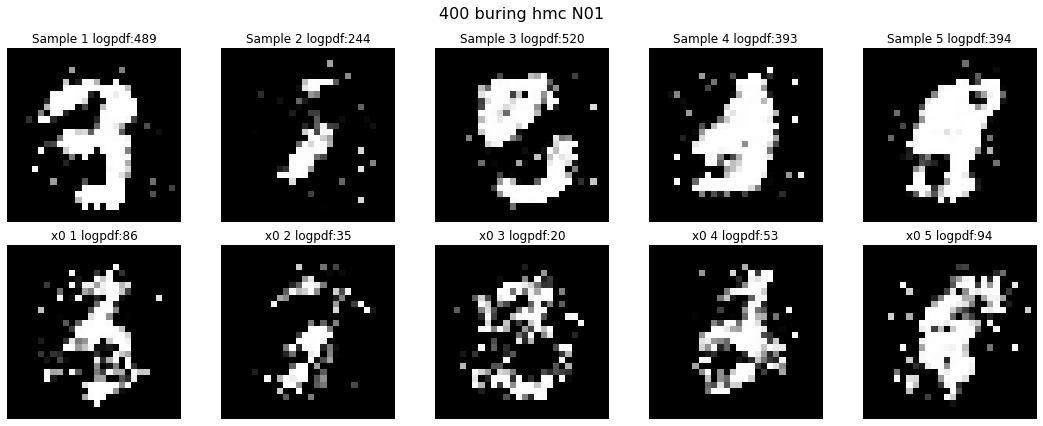

In [250]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and x0_noises are already defined

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("400 buring hmc N01", fontsize=16)

for i in range(5):
    # Top row: true samples
    axes[0, i].imshow(reverse_transform(torch.tensor(sample_GG_CNN[i])).reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Sample {i+1} logpdf:'+str(int(sample_pdf[i])))

    # Bottom row: x0 points
    axes[1, i].imshow(reverse_transform(torch.tensor(x0_noises[i])).reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'x0 {i+1} logpdf:'+str(int(x0_pdf[i])))

plt.tight_layout()
plt.show()

In [198]:
print('100burnin 10 epoch',W2(X_train.reshape(-1,28*28).float(),torch.tensor(sample_GG_CNN).reshape(-1,28*28).float())
)

100burnin 10 epoch tensor(37.3038)


In [77]:
print('100burnin 10 epoch',W2(X_train.reshape(-1,28*28).float(),torch.tensor(sample_GG_CNN_500).reshape(-1,28*28).float())
)

100burnin 10 epoch tensor(36.4794)


In [41]:
samples_norm = scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=np.cov(X_train.reshape(-1,28*28).T), size=25).reshape(-1,1,28,28)

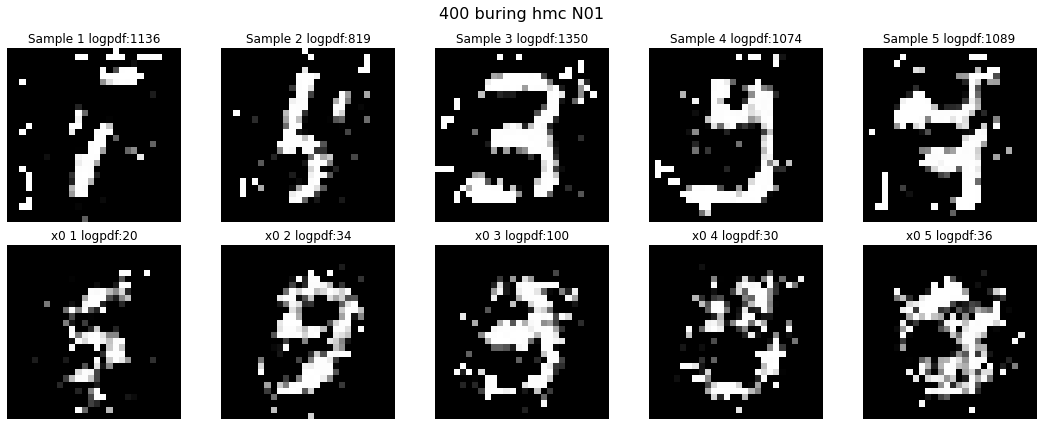

In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and x0_noises are already defined

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("400 buring hmc N01", fontsize=16)

for i in range(5):
    # Top row: true samples
    axes[0, i].imshow(reverse_transform(torch.tensor(sample_GG_CNN[i])).reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Sample {i+1} logpdf:'+str(int(sample_pdf[i])))

    # Bottom row: x0 points
    axes[1, i].imshow(reverse_transform(torch.tensor(x0_noises[i])).reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'x0 {i+1} logpdf:'+str(int(x0_pdf[i])))

plt.tight_layout()
plt.show()

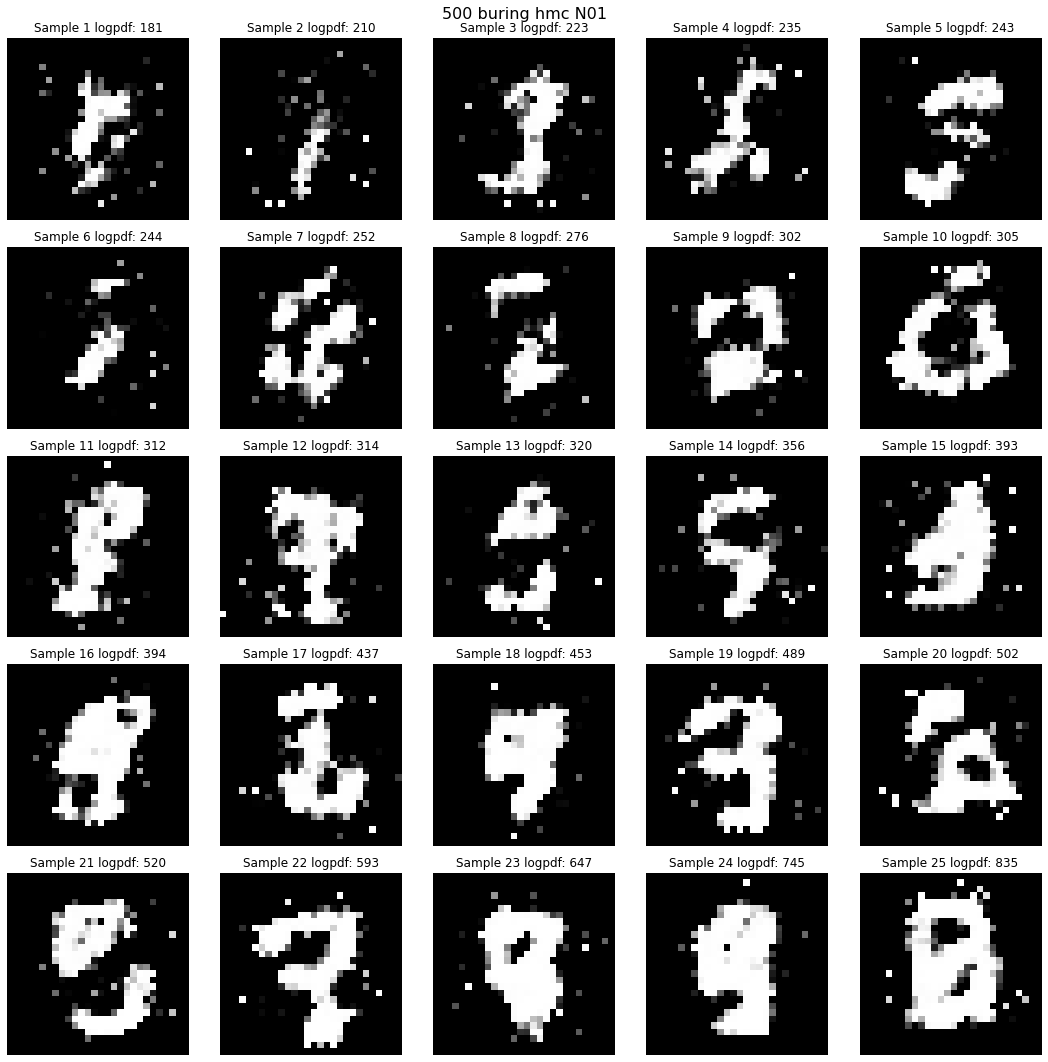

In [249]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and sample_pdf are already defined

# Combine samples and logpdf values into a list of tuples
samples_with_logpdf = list(zip(sample_GG_CNN, sample_pdf))


# title
# Sort the list based on logpdf values
samples_with_logpdf.sort(key=lambda x: x[1])

# Unzip the sorted list
sorted_samples, sorted_logpdf = zip(*samples_with_logpdf)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("500 buring hmc N01", fontsize=16)

for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        axes[i, j].imshow(reverse_transform(torch.tensor(sorted_samples[idx])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {idx+1} logpdf: {int(sorted_logpdf[idx])}')

plt.tight_layout()
plt.show()

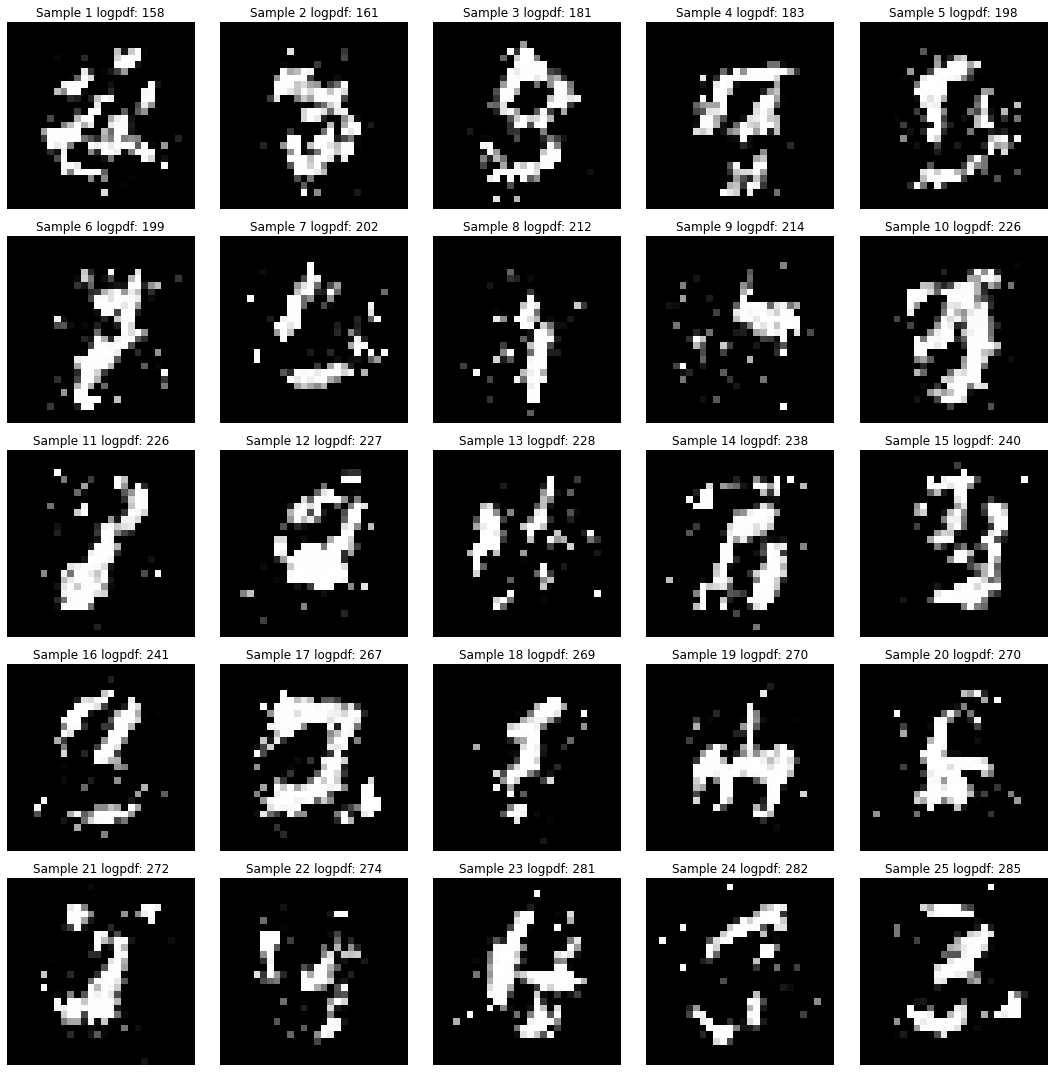

In [76]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and sample_pdf are already defined

# Combine samples and logpdf values into a list of tuples
samples_with_logpdf = list(zip(sample_GG_CNN_500, sample_pdf))

# Sort the list based on logpdf values
samples_with_logpdf.sort(key=lambda x: x[1])

# Unzip the sorted list
sorted_samples, sorted_logpdf = zip(*samples_with_logpdf)

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        idx = i * 5 + j
        axes[i, j].imshow(reverse_transform(torch.tensor(sorted_samples[idx])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {idx+1} logpdf: {int(sorted_logpdf[idx])}')

plt.tight_layout()
plt.show()

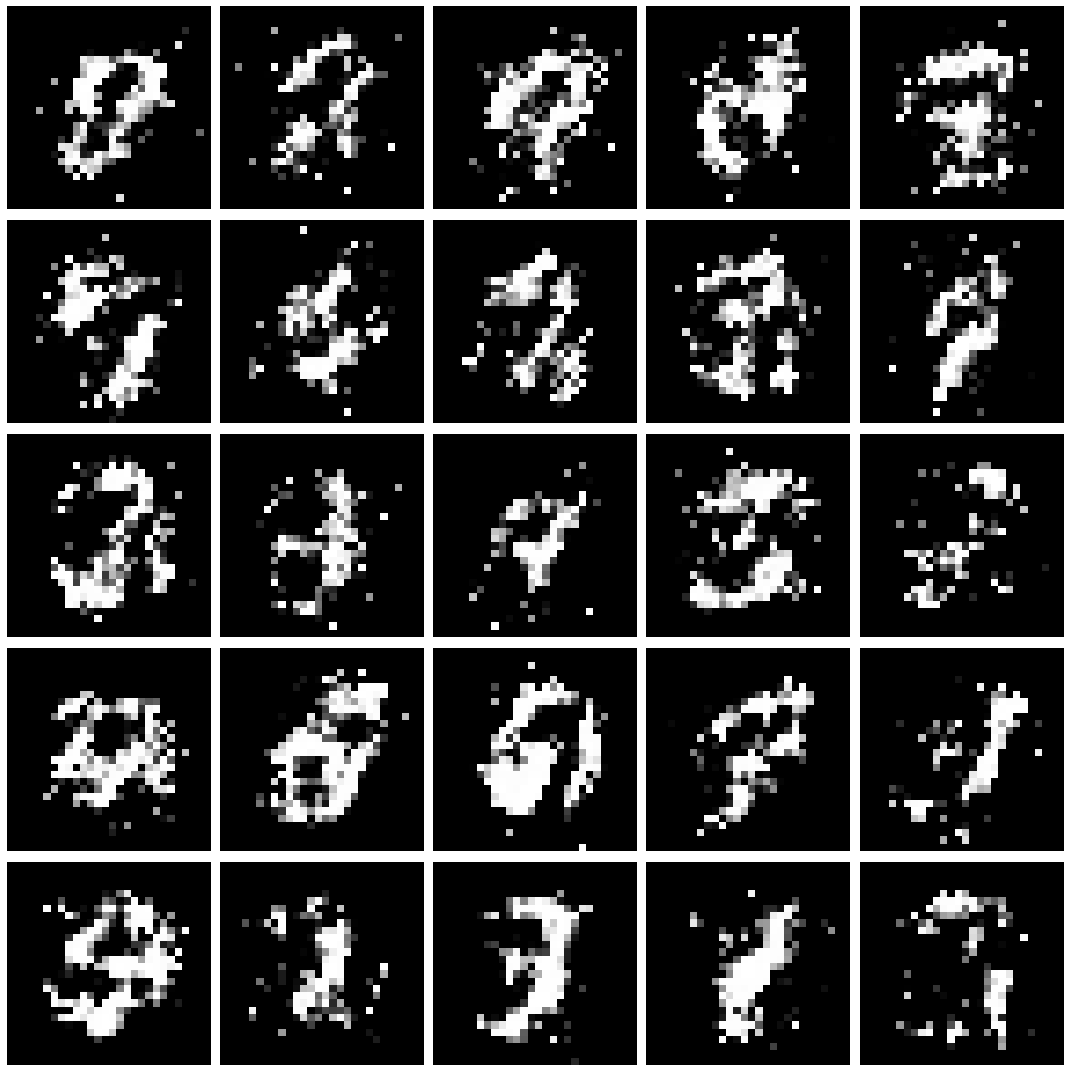

In [130]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform and sample_GG_CNN are already defined

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i in range(5):
    for j in range(5):
        axes[i, j].imshow(reverse_transform(torch.tensor(sample_GG_CNN[i * 5 + j])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# simple ratio

In [323]:
from Ratio import *

def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


# Define model
ratio = Ratio(h_dim=100, in_dim=28*28, h_layers=2, normalising_cst=True)

# Define loss function and optimizer
optimizer = torch.optim.Adam(
    [{'params': [param for param in ratio.parameters() if param is not ratio.c]},
    {'params': [ratio.c]}]  # Adjust the learning rate for ratio.c here
)
n_indep = 10

# Training loop
num_epochs = 20

GG_cov = np.cov(X_train.reshape(-1,28*28).T)

for epoch in tqdm(range(num_epochs)):
    ratio.train()
    running_loss = 0.0
    noise_index = 0 

    epoch_GG_noise = torch.tensor(scs.multivariate_normal.rvs(mean=np.zeros(28*28), cov=GG_cov, size=n_indep*64).reshape(-1,1,28,28)).float()
    for inputs, labels in (train_loader):
        optimizer.zero_grad()
        r_p = ratio(inputs.reshape(-1,28*28)).squeeze()
        r_q = ratio( epoch_GG_noise.reshape(-1,28*28)) # torch.randn(inputs.shape).reshape(-1,1,28,28)).squeeze() #
        noise_index += inputs.shape[0]
        loss = loss_nce(r_p, r_q,inputs.shape[0], n_indep*inputs.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {ratio.c.item()}")



  5%|▌         | 1/20 [00:04<01:33,  4.93s/it]

Epoch 1/20, Loss: 0.32872349629824016, c: 1.0181527137756348


 10%|█         | 2/20 [00:10<01:32,  5.15s/it]

Epoch 2/20, Loss: 2.7066104467839067, c: 1.0324815511703491


 15%|█▌        | 3/20 [00:15<01:24,  5.00s/it]

Epoch 3/20, Loss: 2.485840407229944, c: 1.0802608728408813


 20%|██        | 4/20 [00:20<01:24,  5.30s/it]

Epoch 4/20, Loss: 1.533973142028109, c: 1.0914734601974487


 25%|██▌       | 5/20 [00:25<01:18,  5.22s/it]

Epoch 5/20, Loss: 1.2188107087286806, c: 1.1020100116729736


 30%|███       | 6/20 [00:30<01:10,  5.04s/it]

Epoch 6/20, Loss: 1.0482215861648894, c: 1.108361005783081


 35%|███▌      | 7/20 [00:35<01:04,  4.94s/it]

Epoch 7/20, Loss: 0.9358552498286212, c: 1.1139031648635864


 40%|████      | 8/20 [00:40<00:59,  4.94s/it]

Epoch 8/20, Loss: 0.905124163751536, c: 1.1158722639083862


 45%|████▌     | 9/20 [00:44<00:53,  4.88s/it]

Epoch 9/20, Loss: 0.7897727077783171, c: 1.120627999305725


 50%|█████     | 10/20 [00:49<00:48,  4.86s/it]

Epoch 10/20, Loss: 0.7125215679645411, c: 1.1237883567810059


 55%|█████▌    | 11/20 [00:55<00:45,  5.03s/it]

Epoch 11/20, Loss: 0.6889979256225675, c: 1.129150629043579


 60%|██████    | 12/20 [01:00<00:40,  5.03s/it]

Epoch 12/20, Loss: 0.6234924940308973, c: 1.1344035863876343


 65%|██████▌   | 13/20 [01:05<00:34,  4.97s/it]

Epoch 13/20, Loss: 0.6597760583736749, c: 1.1408456563949585


 70%|███████   | 14/20 [01:09<00:29,  4.93s/it]

Epoch 14/20, Loss: 0.5682563067181532, c: 1.147487759590149


 75%|███████▌  | 15/20 [01:14<00:24,  4.86s/it]

Epoch 15/20, Loss: 0.5764367566394336, c: 1.1523314714431763


 80%|████████  | 16/20 [01:19<00:19,  4.83s/it]

Epoch 16/20, Loss: 0.48529296630084007, c: 1.1556990146636963


 85%|████████▌ | 17/20 [01:24<00:14,  4.99s/it]

Epoch 17/20, Loss: 0.5347776970645385, c: 1.1615968942642212


 90%|█████████ | 18/20 [01:29<00:10,  5.06s/it]

Epoch 18/20, Loss: 0.45674041343300836, c: 1.1656838655471802


 95%|█████████▌| 19/20 [01:35<00:05,  5.11s/it]

Epoch 19/20, Loss: 0.44360158545201395, c: 1.1686841249465942


100%|██████████| 20/20 [01:39<00:00,  5.00s/it]

Epoch 20/20, Loss: 0.45466478382831, c: 1.1681149005889893


In [305]:
samples_NNEt, log_pdf_NNEt, x0_noises_NNEt = sample_GG_hmc(GG_ratio_model=model_GG_CNN, 
                            num_samples=1, 
                            num_runs_hmc=5,
                            num_burnin=150)
print(samples_NNEt.shape)

100%|██████████| 5/5 [00:34<00:00,  6.90s/it]

(5, 784)


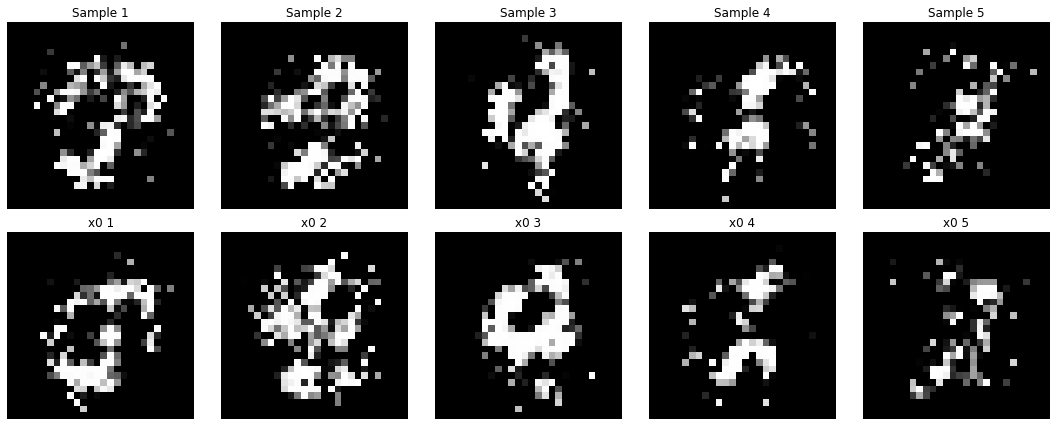

In [306]:
import matplotlib.pyplot as plt
import torch

# Assuming reverse_transform, sample_GG_CNN, and x0_noises are already defined

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Top row: true samples
    axes[0, i].imshow(reverse_transform(torch.tensor(samples_NNEt[i])).reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Sample {i+1}')

    # Bottom row: x0 points
    axes[1, i].imshow(reverse_transform(torch.tensor(x0_noises_NNEt[i])).reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'x0 {i+1}')

plt.tight_layout()
plt.show()

# KD ratio

In [11]:
import torch
from torch.distributions import MultivariateNormal, Normal
from torch.distributions.distribution import Distribution

In [266]:
from torch.special import logsumexp

X_train_cov = torch.tensor(np.cov(X_train.T))
def kde_logpdf(x_single, X_seen, variance):
    d = X_seen.shape[1]
    n = X_seen.shape[0]

    mvn = MultivariateNormal(loc=torch.zeros(d), covariance_matrix=torch.eye(d)*1e-6 +X_train_cov* variance)
    log_probs = mvn.log_prob(x_single - X_seen)
    return logsumexp(log_probs, dim=0) - torch.log(torch.tensor(n, dtype=torch.float32))



In [276]:
for v in np.linspace(1.4,2.5,10):
    out = [kde_logpdf(torch.tensor(X_train[100+i].reshape(-1,28*28)),torch.tensor(X_train[:50].reshape(-1,28*28)),v) for i in range(50)]
    print(v,np.mean(out))

C:\Users\david\AppData\Local\Temp\ipykernel_20700\1435831671.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [kde_logpdf(torch.tensor(X_train[100+i].reshape(-1,28*28)),torch.tensor(X_train[:50].reshape(-1,28*28)),v) for i in range(50)]


1.4 -1195.7885375716048
1.5222222222222221 -1190.3224916578758
1.6444444444444444 -1188.0098225971424
1.7666666666666666 -1188.033738369991
1.8888888888888888 -1189.8099132058076
2.011111111111111 -1192.9119963135463
2.1333333333333333 -1197.023613056715
2.2555555555555555 -1201.906568698595


KeyboardInterrupt: 

In [159]:
# Define the ratio copula for MNIST data (28x28 images)

class CNN_ratio_MNIST(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), normalising_cst=True, c=1.0):
        super(CNN_ratio_MNIST, self).__init__()
        self.normalising_cst = normalising_cst
        if self.normalising_cst:
            self.c = nn.Parameter(torch.tensor(c))

        self.model = nn.Sequential(
            nn.Conv2d(in_shape[0], 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 1)  # Adjusted for 28x28 input images
        )

    def forward(self, x):
        logits = self.model(x).exp()
        if self.normalising_cst:
            logits = logits * self.c
        return logits

In [162]:
from tqdm import tqdm

In [165]:
X_train.shape

torch.Size([30000, 784])

In [248]:


def loss_nce(r_p, r_q,p_size, q_size):
    v = q_size / p_size
    return (-(r_p /(v+r_p)).log()).mean() - v* ((v/(v+r_q)).log().mean()) 


# Define model
model_KD_CNN = CNN_ratio_MNIST()

# Define loss function and optimizer
optimizer = optim.Adam(model_KD_CNN.parameters())#, lr=0.0002, betas=(0.5, 0.999))

n_indep = 10

# Training loop
num_epochs = 30


for epoch in tqdm(range(num_epochs)):
    model_KD_CNN.train()
    running_loss = 0.0
    noise_index = 0 

    for inputs, labels in (train_loader):
        optimizer.zero_grad()
        r_p = model_KD_CNN(inputs).squeeze()
        epoch_KD_noise_here = 0.5*torch.randn(inputs.shape[0],28*28)+X_train[np.random.choice(X_train.shape[0], inputs.shape[0], replace=True)]
        r_q = model_KD_CNN(epoch_KD_noise_here.reshape(-1,1,28,28).float()).squeeze()
        noise_index += inputs.shape[0]
        loss = loss_nce(r_p, r_q,inputs.shape[0], epoch_KD_noise_here.shape[0])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, c: {model_KD_CNN.c.item()}, r_p: {r_p.mean().item()}, r_q: {r_q.mean().item()}")



  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:35<17:19, 35.83s/it]

Epoch 1/30, Loss: 0.22273732060546686, c: 1.0435791015625, r_p: 8234.7958984375, r_q: 0.003195367055013776


  7%|▋         | 2/30 [01:13<17:12, 36.88s/it]

Epoch 2/30, Loss: 0.04902835123028471, c: 1.045262098312378, r_p: 966563.0625, r_q: 0.035061731934547424


 10%|█         | 3/30 [02:08<20:13, 44.96s/it]

Epoch 3/30, Loss: 0.03982063763087858, c: 1.0464264154434204, r_p: 79932.578125, r_q: 0.0001255031384062022


 13%|█▎        | 4/30 [03:00<20:49, 48.06s/it]

Epoch 4/30, Loss: 0.024407837413815355, c: 1.0478599071502686, r_p: 10625273.0, r_q: 0.008950644172728062


 17%|█▋        | 5/30 [03:41<18:55, 45.43s/it]

Epoch 5/30, Loss: 0.020399531448703767, c: 1.04837965965271, r_p: 250870416.0, r_q: 0.00028223046683706343


 17%|█▋        | 5/30 [04:10<20:52, 50.08s/it]


KeyboardInterrupt: 

In [244]:
model_KD_CNN.eval()


# LL computation

subset_num = 100

# KD logpdf
KD_train_log_pdf = torch.zeros(subset_num)
for i in tqdm(range(subset_num)):
    KD_train_log_pdf[i] = kde_logpdf(torch.tensor(X_train[i].reshape(-1,28*28)),torch.tensor(X_train.reshape(-1,28*28)),0.2)

KD_test_logpdf = torch.zeros(subset_num)
for i in tqdm(range(subset_num)):
    KD_test_logpdf[i] = kde_logpdf(torch.tensor(X_test[i].reshape(-1,28*28)),torch.tensor(X_train.reshape(-1,28*28)),0.2)

# Define the standard normal distribution
standard_normal = dist.Normal(loc=0, scale=1)
# Compute logpdf for the standard normal distribution and sum over the dimensions
logpdf_standard_train = standard_normal.log_prob(X_train[:subset_num].reshape(-1,28*28)).sum(dim=1)
logpdf_standard_test = standard_normal.log_prob(X_test[:subset_num].reshape(-1,28*28)).sum(dim=1)
# Compute GG_correction
GG_correction_train = KD_train_log_pdf - logpdf_standard_train
GG_correction_test = KD_test_logpdf - logpdf_standard_test
# Compute means
mean_GG_correction_train = GG_correction_train.mean()
mean_GG_correction_test = GG_correction_test.mean()




  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Temp\ipykernel_20700\3642518906.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  KD_train_log_pdf[i] = kde_logpdf(torch.tensor(X_train[i].reshape(-1,28*28)),torch.tensor(X_train.reshape(-1,28*28)),0.2)
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\david\AppData\Local\Temp\ipykernel_20700\3642518906.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  KD_test_logpdf[i] = kde_logpdf(torch.tensor(X_test[i].reshape(-1,28*28)),torch.tensor(X_train.reshape(-1,28*28)),0.2)
100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


In [203]:
mean_GG_correction_train,mean_GG_correction_test

(tensor(-2762.5044), tensor(-2819.6516))

In [252]:
# GG_CNN_Ratio

# Compute GG ratio alone
gg_CNN_ratio_train = model_KD_CNN(X_train[:subset_num].reshape(-1,1,28,28)).log().mean()
gg_CNN_ratio_test = model_KD_CNN(X_test[:subset_num].reshape(-1,1,28,28)).log().mean()

# Compute GG ratio corrected
gg_CNN_ratio_corrected_train = (GG_correction_train + model_KD_CNN(X_train[:subset_num].reshape(-1,1,28,28)).log()).mean()
gg_CNN_ratio_corrected_test = (GG_correction_test + model_KD_CNN(X_test[:subset_num].reshape(-1,1,28,28)).log()).mean()

# Print the results
print('GG CNN ratio alone', gg_CNN_ratio_train.item(), gg_CNN_ratio_test.item())
print('GG CNN ratio corrected ; GG_ratio full', gg_CNN_ratio_corrected_train.item(), gg_CNN_ratio_corrected_test.item())


GG CNN ratio alone 14.250435829162598 14.328974723815918
GG CNN ratio corrected ; GG_ratio full 1018.961181640625 -1613.2159423828125


C:\Users\david\AppData\Local\Temp\ipykernel_20700\2934232147.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  axes[i, j].imshow(reverse_transform(torch.randn(1,28*28)*0.2+torch.tensor(X_train[np.random.choice(X_train.shape[0], 1, replace=True)])).reshape(28, 28), cmap='gray')


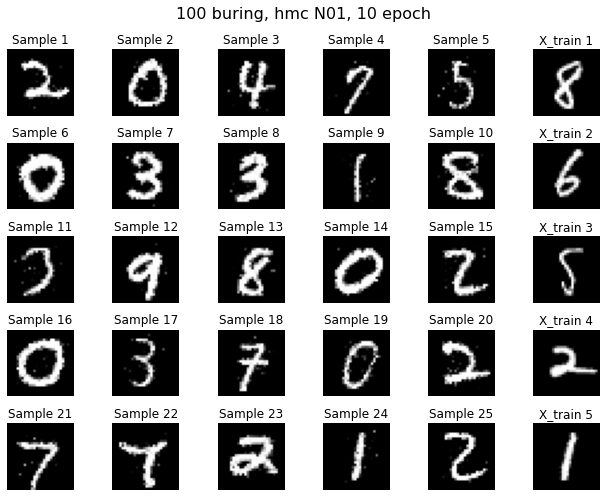

In [188]:
import matplotlib.pyplot as plt
import torch
fig, axes = plt.subplots(5, 6, figsize=(9, 7))
fig.suptitle("100 buring, hmc N01, 10 epoch", fontsize=16)

for i in range(5):
    for j in range(5):
        # First 5 columns: samples_100burn_19epoch
        axes[i, j].imshow(reverse_transform(torch.randn(1,28*28)*0.2+torch.tensor(X_train[np.random.choice(X_train.shape[0], 1, replace=True)])).reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f'Sample {i * 5 + j + 1}')
    
    # Last column: X_train images
    axes[i, 5].imshow(reverse_transform(X_train[i]).reshape(28, 28), cmap='gray')
    axes[i, 5].axis('off')
    axes[i, 5].set_title(f'X_train {i + 1}')

plt.tight_layout()
plt.show()
